In [5]:
# Copyright (c) 2012 The Chromium OS Authors. All rights reserved.
# Use of this source code is governed by a BSD-style license that can be
# found in the LICENSE file.

# Adapted by Srayan Gangopadhyay, 2023-02-22


import cv2
import math
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
# import matplotlib
import itertools
import pickle


# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# plt.rcParams['figure.figsize'] = [4, 4]
# plt.figure().set_size_inches(w=4.7747, h=4.2)


def _ExtractPatch(sample, edge_start, edge_end, desired_width, crop_ratio):
    """Crops a patch from the test target."""
    # Identify the edge direction.
    vec = edge_end - edge_start
    # Discard both ends so that we MIGHT not include other edges
    # in the resulting patch.
    # TODO: Auto-detect if the patch covers more than one edge!
    safe_start = (1 - crop_ratio) * edge_start + crop_ratio * edge_end
    safe_end = crop_ratio * edge_start + (1 - crop_ratio) * edge_end
    minx = int(round(min(safe_start[0], safe_end[0])))
    miny = int(round(min(safe_start[1], safe_end[1])))
    maxx = int(round(max(safe_start[0], safe_end[0])))
    maxy = int(round(max(safe_start[1], safe_end[1])))
    if abs(vec[0]) > abs(vec[1]):  # near-horizontal edge
        ylb = max(0, miny - desired_width)
        yub = min(sample.shape[0], maxy + desired_width + 1)
        patch = np.transpose(sample[ylb:yub, minx : (maxx + 1)])
    else:  # near-vertical edge
        xlb = max(0, minx - desired_width)
        xub = min(sample.shape[1], maxx + desired_width + 1)
        patch = sample[miny : (maxy + 1), xlb:xub]
    # Make sure white is on the left.
    if patch[0, 0] < patch[-1, -1]:
        patch = np.fliplr(patch)
    # Make a floating point copy.
    patch = np.asfarray(patch)
    # TODO(sheckylin) Correct for vignetting.
    return patch


def _FindEdgeSubPix(patch, desired_width):
    """Locates the edge position for each scanline with subpixel precision."""
    ph = patch.shape[0]
    pw = patch.shape[1]
    # Get the gradient magnitude along the x direction.
    k_gauss = np.transpose(cv2.getGaussianKernel(7, 1.0))
    temp = cv2.filter2D(patch, -1, k_gauss, borderType=cv2.BORDER_REFLECT)
    k_diff = np.array([[-1, 1.0]])
    grad = abs(cv2.filter2D(temp, -1, k_diff, borderType=cv2.BORDER_REPLICATE))
    # Estimate subpixel edge position for each scanline.
    ys = np.arange(ph, dtype=np.float64)
    xs = np.empty(ph, dtype=np.float64)
    x_dummy = np.arange(pw, dtype=np.float64)
    for y in range(ph):
        # 1st iteration.
        b = np.sum(x_dummy * grad[y])
        a = np.sum(grad[y])
        c = int(round(b / a))
        # 2nd iteration due to bias of different num of black and white pixels.
        dw = min(min(c, desired_width), pw - c - 1)
        b = np.sum(x_dummy[(c - dw) : (c + dw + 1)] * grad[y, (c - dw) : (c + dw + 1)])
        a = np.sum(grad[y, (c - dw) : (c + dw + 1)])
        xs[y] = int(round(b / a))
    # Fit a second-order polyline for subpixel accuracy.
    fitted_line = np.polyfit(ys, xs, 1)
    fitted_parabola = np.polyfit(ys, xs, 2)
    angle = math.atan(fitted_line[0])
    pb = np.poly1d(fitted_parabola)
    centers = [pb(y) for y in range(ph)]
    return angle, centers


def _AccumulateLine(patch, centers):
    """Adds up the scanlines along the edge direction."""
    ph = patch.shape[0]
    pw = patch.shape[1]
    # Determine the final line length.
    w = min(int(round(np.min(centers))), pw - int(round(np.max(centers))) - 1)
    w4 = 2 * w + 1
    # Accumulate a 4x-oversampled line.
    psf4x = np.zeros((4, w4), dtype=np.float64)
    counts = np.zeros(4, dtype=np.float64)
    for y in range(ph):
        ci = int(round(centers[y]))
        idx = 3 + 4 * ci - int(4 * centers[y] + 2)
        psf4x[idx] += patch[y, (ci - w) : (ci + w + 1)]
        counts[idx] += 1
    counts = np.expand_dims(counts, axis=1)
    psf4x /= counts
    esf = psf4x.transpose().flatten()
    psf = np.diff(psf4x.transpose().flatten())
    return psf, esf


def _GetResponse(psf, angle):
    """Composes the MTF curve."""
    w = psf.shape[0]
    # Compute FFT.
    magnitude = abs(np.fft.fft(psf))
    # Smooth the result a little bit.
    # This is equivalent to applying window in the spatial domain
    # as enforced in the Imatest's algorithm.
    k_gauss = np.transpose(cv2.getGaussianKernel(7, 1.0))
    cv2.filter2D(magnitude, -1, k_gauss, magnitude, borderType=cv2.BORDER_REFLECT)
    # Slant correction factor.
    slant_correction = math.cos(angle)
    # Compose MTF curve.
    # Normalize the low frequency response to 1 and compensate for the
    # finite difference.
    rw = int(w / 4 + 1)
    magnitude = magnitude[0:rw] / magnitude[0]
    freqs = np.arange(rw, dtype=np.float64) * 4 / w / slant_correction
    attns = magnitude / (np.sinc(np.arange(rw, dtype=np.float64) / w) ** 2)
    return freqs, attns


def _FindMTF50P(freqs, attns, use_50p):
    """Locates the MTF50P given the MTF curve."""
    peak50 = (attns.max() if use_50p else 1.0) / 2.0
    idx = np.nonzero(attns < peak50)[0]
    if idx.shape[0] == 0:
        return freqs[-1]
    idx = idx[0]
    # Linear interpolation.
    ratio = (peak50 - attns[idx - 1]) / (attns[idx] - attns[idx - 1])
    return freqs[idx - 1] + (freqs[idx] - freqs[idx - 1]) * ratio


def Compute_DEBUG(sample, edge_start, edge_end, desired_width, crop_ratio, use_50p=True):
    patch = _ExtractPatch(sample, edge_start, edge_end, desired_width, crop_ratio)
    angle, centers = _FindEdgeSubPix(patch, desired_width)
    
#     # OPTION 1: 2x2 grid
#     fig, axs = plt.subplots(2, 2)
#     axs[0][0].imshow(patch, cmap='gray')
#     axs[0][0].plot(np.array(centers)+22, np.arange(len(centers)), 'r--', label=f'Fitted angle = {np.rad2deg(angle):.2f} deg')
#     axs[0][0].set_xlim(200, 350)
#     axs[0][0].legend()
#     print(f'Detected edge angle: {np.rad2deg(angle)}')
#     psf, esf = _AccumulateLine(patch, centers)
#     axs[1][0].plot(esf, label='Edge spread function')
#     axs[1][0].legend()
#     axs[0][1].plot(-psf, label='Line spread function')
#     axs[0][1].legend()
#     freqs, attns = _GetResponse(psf, angle)
#     axs[1][1].plot(freqs / 6.45e-3, attns, "-.", label="Modulation transfer function")
#     axs[1][1].set_xlim(0, 0.5 / 6.45e-3)
#     axs[1][1].legend()
#     plt.tight_layout()
#     plt.show()
    
    # OPTION 2: 1x4 array
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(patch, cmap='gray')
    axs[0].plot(np.array(centers)+22, np.arange(len(centers)), 'r--', label=f'Fitted angle = {np.rad2deg(angle):.2f} deg')
    axs[0].set_xlim(200, 350)
    axs[0].set_xlabel('x (px)')
    axs[0].set_ylabel('y (px)')
#     axs[0].legend()
    axs[0].set_title('Edge image')
    print(f'Detected edge angle: {np.rad2deg(angle)}')
    psf, esf = _AccumulateLine(patch, centers)
    axs[1].plot(esf, '-', color='steelblue', label='Edge spread function')
    axs[1].set_title('ESF')
    axs[1].set_xlabel('x\' (px)')
    axs[2].plot(-psf, '-', color='cadetblue', label='Line spread function')
    axs[2].set_title('LSF')
    axs[2].set_xlabel('x\' (px)')
    freqs, attns = _GetResponse(psf, angle)
    axs[3].plot(freqs / 6.45e-3, attns, "--", color='slateblue', label="Modulation transfer function")
    axs[3].set_xlim(0, 0.5 / 6.45e-3)
    axs[3].set_title('MTF')
    axs[3].set_xlabel('spatial freq. (lp/mm)')
    plt.tight_layout()
    plt.savefig("mtf_computation.png", transparent=True, dpi=300)
    plt.show()
    
    return _FindMTF50P(freqs, attns, use_50p), freqs, attns


#################
# OUR FUNCTIONS #
#################


def load_stack(path, x_min=400, x_max=700, y_min=300, y_max=600, show=False):
    imgs = io.imread(path + "/MMStack_Pos0.ome.tif")[:, x_min:x_max, y_min:y_max]
    if show:
        plt.imshow(imgs[0], cmap="gray")
        plt.title(f"Image 1 of {len(imgs)}")
        plt.show()
    print(f"Loaded stack of {imgs.shape[0]} images, dimensions {imgs.shape[1:]}")
    return imgs


def average_stack(imgs, im_per_pos=5, show=False):
    # adapted from: https://stackoverflow.com/a/6972selection[142
    image_sets = imgs.reshape(
        (len(imgs) // im_per_pos, im_per_pos, imgs.shape[1], imgs.shape[2])
    )
    avg_stack = np.mean(image_sets, axis=1)
    if show:
        plt.imshow(avg_stack[0], cmap="gray")
        plt.title(f"Image 1 of {len(avg_stack)}")
        plt.show()
    print(f"Averaged original stack of {len(imgs)} down to {len(avg_stack)}.")
    return avg_stack


def remove_background(imgs, bg_light, bg_dark, show=False):
    # adapted from: https://stackoverflow.com/a/73082666
    imgs_minus_bg = np.clip(imgs - bg_dark, 0, imgs.max())
    light_minus_bg = np.clip(bg_light - bg_dark, 0, bg_light.max())
    divided = np.clip(imgs_minus_bg / light_minus_bg, 0, imgs_minus_bg.max())
    if show:
        f, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes[0][0].imshow(imgs[0], cmap="gray")
        axes[0][0].set_title(f"imgs, 1 of {len(imgs)}")
        axes[0][1].imshow(imgs_minus_bg[0], cmap="gray")
        axes[0][1].set_title(f"imgs_minus_bg, 1 of {len(imgs_minus_bg)}")
        axes[1][0].imshow(light_minus_bg[0], cmap="gray")
        axes[1][0].set_title(f"light_minus_bg, 1 of {len(light_minus_bg)}")
        axes[1][1].imshow(divided[0], cmap="gray")
        axes[1][1].set_title(f"divided, 1 of {len(divided)}")
        plt.tight_layout()
        plt.show()
    print(f"Removed background and divided illumination from {len(divided)} images.")
    return divided


def load_and_divide(img_dir, bg_dir, img_name, bg_light_name, bg_dark_name, crop):
    img_path = str(img_dir + "/" + img_name)
    imgs = load_stack(
        img_path, x_min=crop[0], x_max=crop[1], y_min=crop[2], y_max=crop[3], show=False
    )

    avg_stack = average_stack(imgs)

    bg_light_path = bg_dir + "/" + bg_light_name
    bg_dark_path = bg_dir + "/" + bg_dark_name
    bg_light = average_stack(
        load_stack(
            bg_light_path, x_min=crop[0], x_max=crop[1], y_min=crop[2], y_max=crop[3]
        )
    )
    bg_dark = average_stack(
        load_stack(
            bg_dark_path, x_min=crop[0], x_max=crop[1], y_min=crop[2], y_max=crop[3]
        )
    )

    divided = remove_background(avg_stack, bg_light, bg_dark)
    return divided


def allComputeMTF_DEBUG(
    edge, position, edge_start, edge_end, desired_width, crop_ratio, plot=False
):
    _, freqs, attns = Compute_DEBUG(
        edge, np.array(edge_start), np.array(edge_end), desired_width, crop_ratio
    )

    if plot:
        plt.plot(freqs / 6.45e-3, attns, "-.", label=f"{position} mm")
        plt.xlim(0, 0.5 / 6.45e-3)
        plt.legend()
        plt.xlabel("line pairs / mm")
        plt.ylabel("MTF")

    return freqs / 6.45e-3, attns

In [6]:
plt.rcParams.update({'font.size': 18, 'lines.linewidth': 2})

In [7]:
# SETUP
data_dir = r'D:\MSci_Project\1_Data'
# data_dir = './../../data_store'
bg_dir = data_dir + '/2023-01-17 background images'
img_dir = data_dir + '/2023-02-15 edge depth sweep green'

# initial image crop
crop = [400, 700, 250, 750]

# mtf patch
edge_start = [100, 100]
edge_end = [400, 500]
desired_width = 100
crop_ratio = 1

SAVE_PLOTS = False
SAVE_MTFS = True
selection = [12, 11, 4]
depths = np.arange(9.45, 15.7, 0.25)

Loaded stack of 125 images, dimensions (300, 500)
Averaged original stack of 125 down to 25.
Loaded stack of 5 images, dimensions (300, 500)
Averaged original stack of 5 down to 1.
Loaded stack of 5 images, dimensions (300, 500)
Averaged original stack of 5 down to 1.
Removed background and divided illumination from 25 images.
Detected edge angle: 5.747649551076277


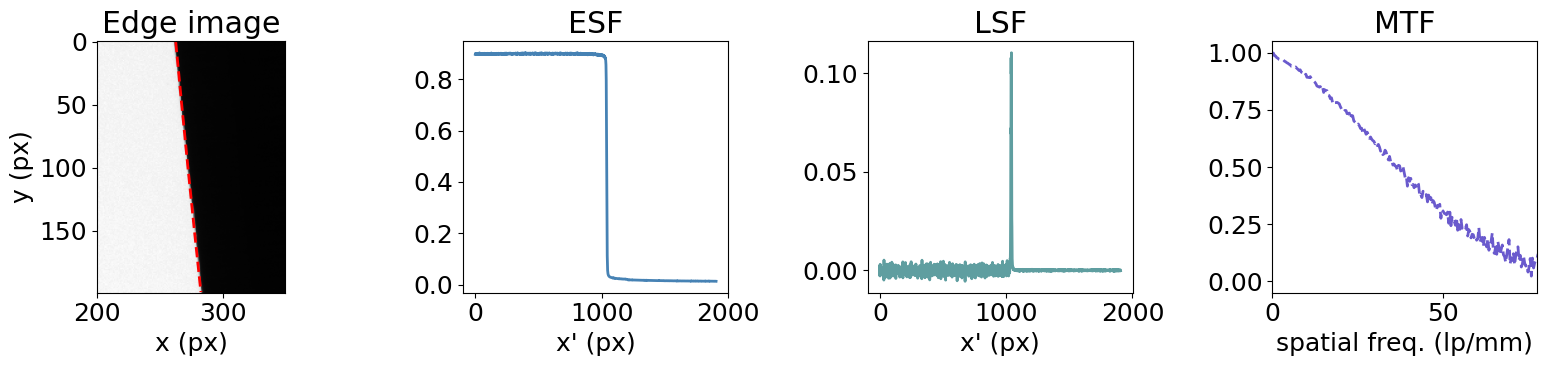

In [8]:
edge = load_and_divide(img_dir, bg_dir, 
    '2023-02-15 fa', '2023-01-17 bg light f-a', '2023-01-17 bg dark f-a', crop
    )

# gen_MTF_plots(edge, '6', depths, selection, edge_start, edge_end, desired_width, crop_ratio, save_plots=SAVE_PLOTS, save_mtfs=SAVE_MTFS)
freqs, mtf = allComputeMTF_DEBUG(
    np.fliplr(np.flipud(edge[12])),
    depths[12],
    edge_start,
    edge_end,
    desired_width,
    crop_ratio,
    plot=False,
)